# Import Necessary Module

In [ ]:
%%capture
!pip install deeplake

In [ ]:
#import Necessary Independencies
%%capture
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import deeplake
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import pandas as pd
import cv2
from scipy import ndimage
from IPython.display import clear_output

In [ ]:
%%capture
ds = deeplake.load('hub://activeloop/mura-train@firstdbf9474d461a19e9333c2fd19b46115348f')
ds_validation = deeplake.load("hub://activeloop/mura-val", reset=True)

In [ ]:
dataloader = ds.pytorch(num_workers=0, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:137: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


# Inspect the Data
Look at image using .numpy object of the tensor

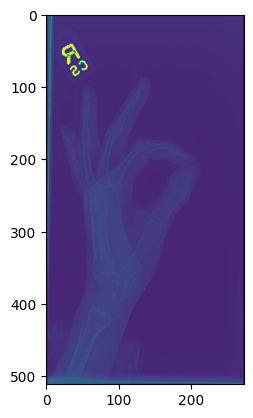

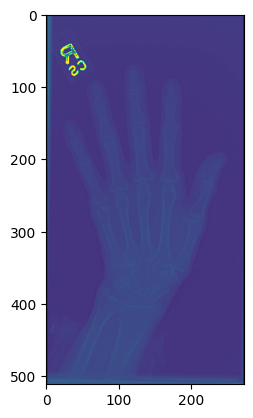

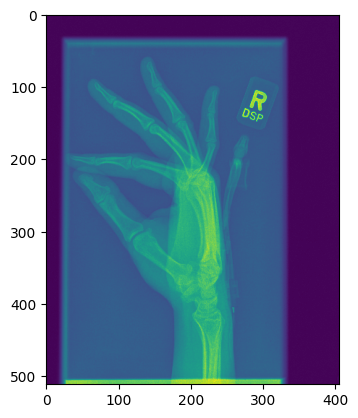

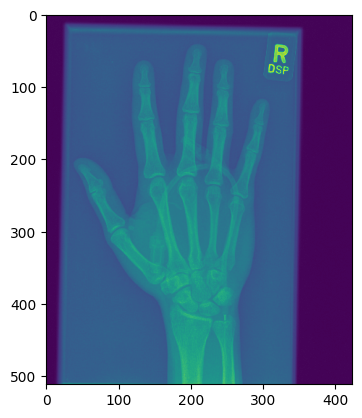

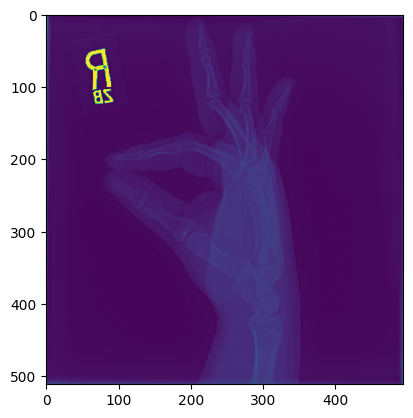

In [ ]:
for i in range(5):
  image = ds['images'][i].numpy(aslist=True)

  plt.imshow(image)
  plt.show()

#Image Processing
Including HPF, Resizing and Crop


In [ ]:
import cv2

def highpass_filter(image):
    # Apply a Gaussian blur for low-pass filtering (adjust kernel size as needed)
    low_pass = cv2.GaussianBlur(image, (21, 21), 0)

    # Subtract the low-pass filtered image from the original to obtain the high-pass filtered image
    high_pass = image - low_pass
    return high_pass

def resize_image(image, target_width, target_height):
    # Resize the image to the specified width and height
    resized_image = cv2.resize(image, (target_width, target_height))
    return resized_image

def crop_image(image, target_width, target_height):
    # Get the dimensions of the original image
    height, width = image.shape[:2]

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate crop box dimensions
    crop_x1 = max(center_x - target_width // 2, 0)
    crop_x2 = min(center_x + target_width // 2, width)
    crop_y1 = max(center_y - target_height // 2, 0)
    crop_y2 = min(center_y + target_height // 2, height)

    # Crop the image
    cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]

    # Resize the cropped image to the target width and height
    resized_cropped_image = cv2.resize(cropped_image, (target_width, target_height))

    return resized_cropped_image

def technique(img):
    img = highpass_filter(img)
    img = resize_image(img, 256, 256)
    img = crop_image(img, 228, 228)

    return img

## Test and Fine Tune method for picture cleaning

In [ ]:
refine_img = technique(image)

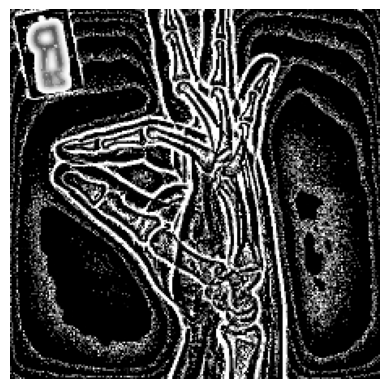

In [ ]:
plt.imshow(refine_img, cmap='gray')
plt.axis('off')
plt.show()

## Process Picture
(Very Long)

In [ ]:
import torch
from PIL import Image
import numpy as np

n = 2500

processed_img = np.array([np.array(Image.fromarray(technique(img)))
for img in ds["images"][:n].numpy(aslist=True)])

print(type(processed_img))
print(type(processed_img[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(type(processed_img))
print((processed_img[0]))

<class 'numpy.ndarray'>
[[  0   1   1 ... 107  11   0]
 [253 116   0 ...   0   0 125]
 [250   0   1 ...   0   0   0]
 ...
 [253 241 107 ...  20   0   0]
 [252 231   2 ...   0   0 250]
 [125   2   2 ...   0 116 128]]


# Visualize Data



## Processed Picture

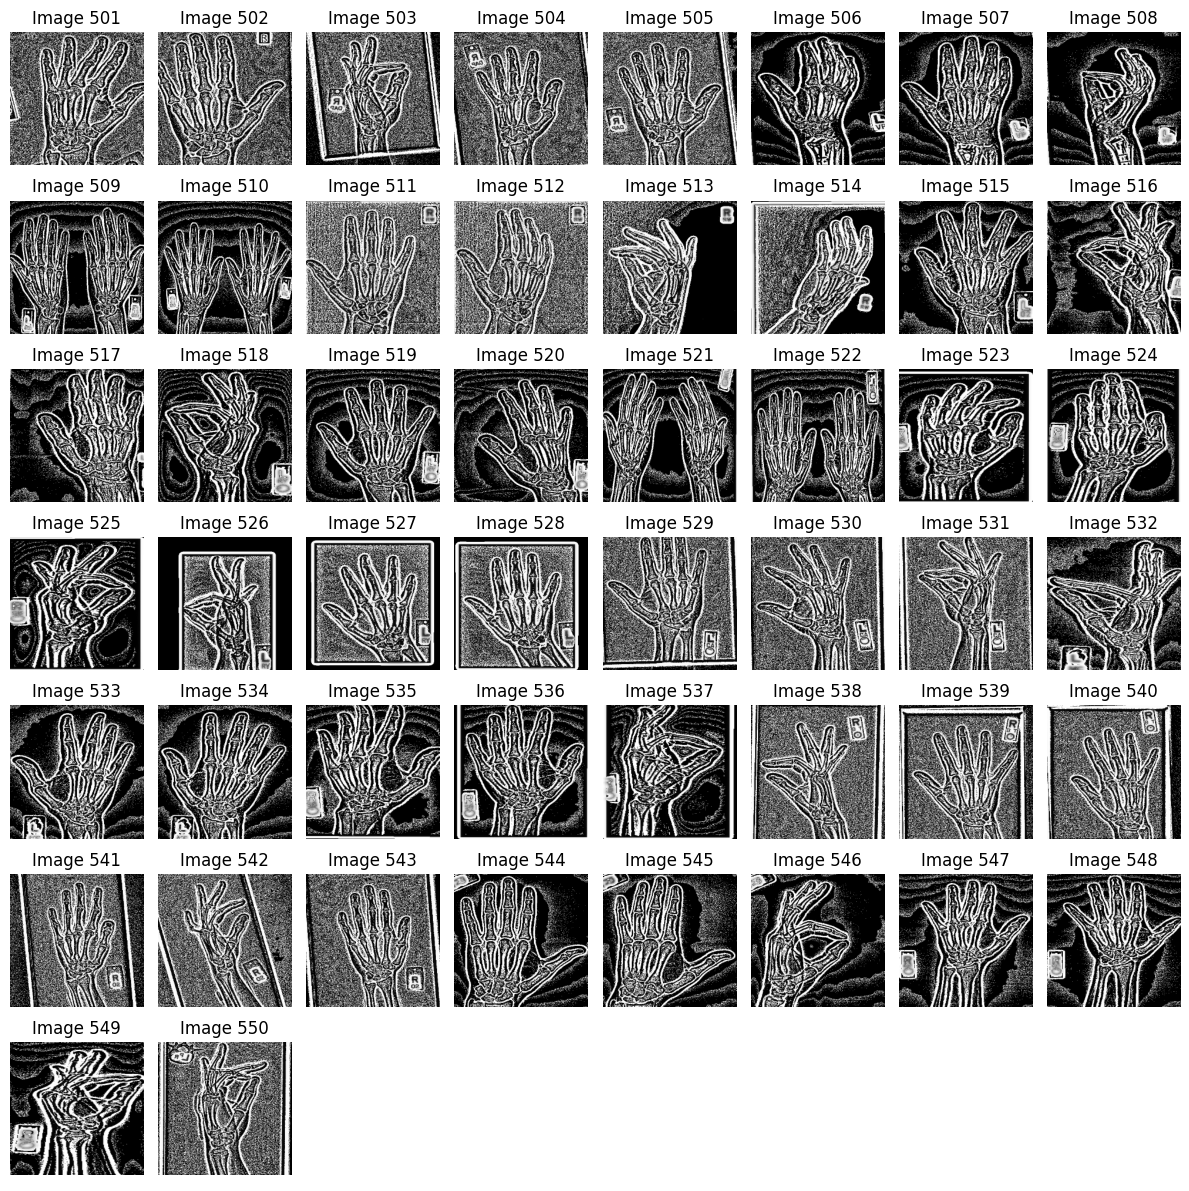

In [ ]:
def visualize_images(images, num_rows=None, nStart=None, nStop=None, cmap='gray', figsize=(12, 12)):
    if nStart is not None and nStop is not None:
        images = images[nStart:nStop]

    num_images = images.shape[0]

    if num_rows is None:
        num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    if num_images == 1:
        axes = [axes]

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i], cmap=cmap)
            ax.set_title(f"Image {nStart + i + 1}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(processed_img, nStart=500, nStop=550)

#Choosing the Data

## All Comlumns
1. images: tensor containing the image.
2. region: tensor containing the name of one of the seven regions of studies such as elbow, finger, forearm, hand, humerus, shoulder, and wrist to which the image belongs to.
3. study: tensor containing the studies.
4. study_type: tensor containing the study type which can be either positive or negative.
5. patient_id: tensor containing the id of the patient.

## Chosen Columns
1. images: the data set of all xray struture
2. region: label of this region ! may revisit this later
3. study_type: is it positive or negative

In [ ]:
flat = np.array(processed_img)
print(len(flat))
print(flat.flatten())  # Corrected method name to flatten()

2500
[  0   1   1 ... 191   1 192]


In [ ]:
import pandas as pd

# Assuming ds['region'] and ds['study_type'] are already NumPy arrays
data = {
    "images": np.array(np.array(e).flatten() for e in np.array(processed_img)),  # Flatten the images
    # "regions": ds["region"][:n].numpy().flatten(),  # Flatten the regions array
    "types": ds["study_type"][:n].numpy().flatten()  # Flatten the study_type array
}

# Create the DataFrame
df = pd.DataFrame(data)

# Verify the shape of the DataFrame
print("DataFrame shape:", df.shape)

DataFrame shape: (2500, 2)


In [ ]:
df.head()

,images,types
0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 119, 1...",0
1,"[1, 1, 1, 1, 2, 1, 1, 1, 75, 44, 92, 26, 110, ...",0
2,"[253, 252, 250, 250, 250, 250, 249, 249, 249, ...",1
3,"[251, 211, 3, 2, 3, 3, 4, 142, 252, 253, 252, ...",1
4,"[0, 128, 127, 0, 0, 0, 110, 118, 254, 8, 32, 0...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  2500 non-null   object
 1   types   2500 non-null   uint32
dtypes: object(1), uint32(1)
memory usage: 29.4+ KB


In [ ]:
df.describe()

,types
count,2500.000000
mean,0.716000
std,0.451027
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


#Split the Data
Use Train-Test split of scipy to split the data, choose 60:40 train-test aplit ratio

In [ ]:
X = df.drop(columns=['types'])
y = df['types']

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.metrics import accuracy_score

# Create a StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

# Assuming you have your data in X and y
for train_index, test_index in stratified_splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Training the model Using Pytorch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 114 * 114, 128)
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes for classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 114 * 114)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Convert data to PyTorch tensors
X_train_flattened = np.concatenate(X_train["images"].values)
X_test_flattened = np.concatenate(X_test["images"].values)
y_train = y_train.ravel().astype(np.int64)
y_test = y_test.ravel().astype(np.int64)

# Reshape the flattened images to the appropriate shape
X_train_reshaped = X_train_flattened.reshape(-1, 1, 228, 228)
X_test_reshaped = X_test_flattened.reshape(-1, 1, 228, 228)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)


# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
# Optimizer and learning rates
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate decay after 5 epochs


In [ ]:
vvj# Training loop with scheduler step
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    scheduler.step()  # Update the learning rate

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")


# Testing
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy: {accuracy}")


Epoch [1/50] - Loss: 0.5977 - Accuracy: 71.81%
Epoch [2/50] - Loss: 0.5957 - Accuracy: 72.01%
Epoch [3/50] - Loss: 0.6023 - Accuracy: 71.33%
Epoch [4/50] - Loss: 0.6016 - Accuracy: 71.40%
Epoch [5/50] - Loss: 0.6010 - Accuracy: 71.47%
Epoch [6/50] - Loss: 0.5971 - Accuracy: 71.88%
Epoch [7/50] - Loss: 0.5990 - Accuracy: 71.67%
Epoch [8/50] - Loss: 0.6016 - Accuracy: 71.40%
Epoch [9/50] - Loss: 0.5984 - Accuracy: 71.74%
Epoch [10/50] - Loss: 0.6003 - Accuracy: 71.54%
Epoch [11/50] - Loss: 0.5990 - Accuracy: 71.67%
Epoch [12/50] - Loss: 0.6023 - Accuracy: 71.33%
Epoch [13/50] - Loss: 0.6010 - Accuracy: 71.47%
Epoch [14/50] - Loss: 0.6003 - Accuracy: 71.54%
Epoch [15/50] - Loss: 0.6029 - Accuracy: 71.26%
Epoch [16/50] - Loss: 0.5997 - Accuracy: 71.60%
Epoch [17/50] - Loss: 0.5990 - Accuracy: 71.67%
Epoch [18/50] - Loss: 0.5984 - Accuracy: 71.74%
Epoch [19/50] - Loss: 0.5964 - Accuracy: 71.94%
Epoch [20/50] - Loss: 0.6023 - Accuracy: 71.33%
Epoch [21/50] - Loss: 0.5997 - Accuracy: 71.60%
E